In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
import time
from pathlib import Path
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#takes thresholded heatmap and returns labels for where there are contigious groups of pixels
from scipy.ndimage.measurements import label
import itertools
global count
from  collections import deque
%matplotlib inline

Standard functions used in both the SVC as well as the Sliding Windows

In [2]:
def convert_color(img, conv='YCrCb'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [4]:
# Computes binned color features.  Also performs a resize as the image blocks we are receiving are 64x64
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.concatenate((color1, color2, color3))

In [5]:
# Computes color histogram features. Bins Range, if defined, needs to be changed if reading in images with mpimg.imread
# range of png is 0-1, jpg are 0-255.
# left the bin range out so it would be automatic.
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    # plt.plot(hist_features)
    return hist_features


Here I am getting all the HOG values for the image, and then extracting the features using subsampling.

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, color_space):
    
    draw_img = np.copy(img)
    #This is used only if you trained on png and are using JPEG's
    img = img.astype(np.float32)/255
    """"""
    t=time.time()
    count=0
    heatmap = np.zeros_like(img[:,:,0])
    img_boxes = []
    """"""
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
         
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    # these are going to hold the number of HOG cells, across and down the image
    
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    #size of the original window size we were extracting features from.
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    #how many steps across the HOG array to extract features
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    # NOTE, here we are getting them as a multi dimension array, as opposed to a 
    # feature vector which we got when we trained the model
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    #steps across the X and Y axis. (moving the window around the image across and down.)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            count +=1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #ravel will unroll the feature vectors, and then we stack them with hstack
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            #dont get the same result as when you do it per sub image. there is discontinuties at the edges of the image. 
            #end up with more false positives, but it is faster and we will deal with false positives later. 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            test_features = X_scaler.transform(np.concatenate((spatial_features, hog_features)).reshape(1, -1)) 
            test_prediction = svc.predict(test_features)
            # IF I am using the heat map to draw the boxes, then I dont need to do it here.
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw]+=1
    for box in img_boxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # print(time.time()-t, 'seconds to run, total windows=', count)
    return heatmap,img_boxes #,draw_img,  

The next challenge will be to deal with multiple detections.  For this I will be using the heat map generated in the find_cars() function

In [7]:
def apply_threshold(heatmap, threshold):
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def find_labeled_boxes(labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        boxes.append(bbox)
    # Return the image
    return boxes#, img

In order to smooth out the video, we want to average the bounding boxes over n frames.

In [8]:
def smoothHeat(bboxes = []):
    global found_heat
    found_heat.append(bboxes)
    workingMap = deque(itertools.islice(found_heat, 1))
    averageMap = np.average(workingMap, axis=0)
    # print("averagedBoxes",averagedBoxes )
    
    return averageMap
    

## Working Pipeline to analyze the images

In [9]:
def single_image_pipeline(img):
    global found_heat
    ystart = 400
    ystop = 656
    #trick to search varying window sizes. used to scale the whole image.
    scales = [1, 1.25,1.5, 1.8] # 1.3, 
    threshold = 4
    # use HOG Subsampling to find the vehicles
    for scale in scales:
        #print(scale)
        heatmap, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space)
        heatmap = apply_threshold(heatmap, threshold)
        found_heat.append(heatmap)
    
    #print(heatmap)
    # Use the heat map to determine where the actual cars are.
    
    workingMap = deque(itertools.islice(found_heat, 1))
    averageMap = np.average(workingMap, axis=0)
    labels= label(averageMap)
    hotboxes = find_labeled_boxes(labels)
    for box in hotboxes:
            cv2.rectangle(img, box[0], box[1], (0,0,255), 6)  
    #print("hotboxes", hotboxes)
    return img#, averageMap
    
    

In [10]:
# Model is saved in a pickle file. This reduces time when testing or if picking up dev work later.
pickleCheck = Path("./model.p")
if pickleCheck.is_file():    
    dist_pickle = pickle.load(open("./model.p", "rb"))
    # load the model as well as soms commonly used parameters.
    svc = dist_pickle["svc"] 
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    hog_channel = dist_pickle["hog_channel"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]    
    color_space = dist_pickle["colorspace"]
    X = dist_pickle["X"]
    print("Model Loaded")
else:
    print("Building Model")
    BuildSVC()
    print("Model Built")
X_scaler = StandardScaler().fit(X)


  


Model Loaded


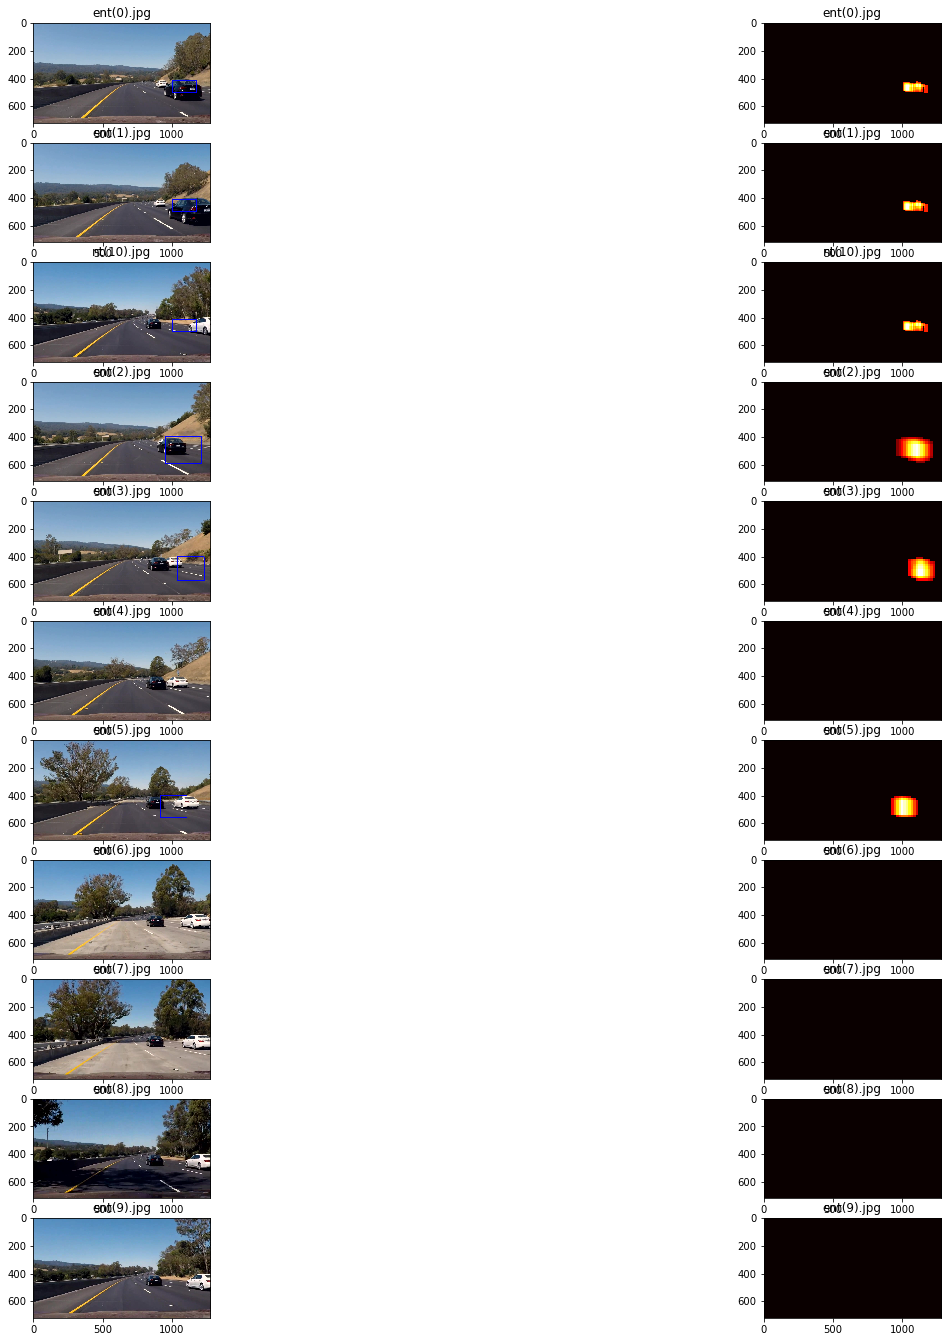

In [68]:
global found_heat

images = glob.glob('./images/clip*.jpg')

processedImages = []
out_maps = []
out_titles = []
out_boxes = []
found_heat = deque(maxlen = 20)
for path in images:    
    img = mpimg.imread(path)
    # use HOG Subsampling to find the vehicles
    out_img, heatmap = single_image_pipeline(img)
    processedImages.append(out_img)
    processedImages.append(heatmap)
    #out_maps.append(heatmap)
    out_titles.append(path[-10:])
    out_titles.append(path[-10:])
fig = plt.figure(figsize=(24,48))
visualize(fig, int(len(processedImages)),2,processedImages, out_titles)

In [11]:
global found_heat
found_heat = deque(maxlen = 2)
output = './OutputVideos/project_video_out.mp4'
clip1 = VideoFileClip("./TestVideos/project_video.mp4")#.subclip(25, 30)
clip = clip1.fl_image(single_image_pipeline) #NOTE: this function expects color images!!

%time clip.write_videofile(output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video ./OutputVideos/project_video_out.mp4
[MoviePy] Writing video ./OutputVideos/project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [35:21<00:01,  1.65s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./OutputVideos/project_video_out.mp4 

Wall time: 35min 21s


## Train the model

In [13]:
def extract_features(imgs, cspace='RGB', spatial_size = (32,32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) 
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)          
            

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)       
        
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [15]:

def BuildSVC():
    cars = []
    notCars = []
    carImages = glob.glob('./Vehicles/*.png')
    for image in carImages:
        cars.append(image)
    nonCarImages = glob.glob('./nonVehicles/*.png')
    for image in nonCarImages:
        notCars.append(image)
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16,16)
    hist_bins=16

    t=time.time()
    spatial_size
    car_features = extract_features(cars, cspace=colorspace, spatial_size = spatial_size, hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=True, hist_feat=False, hog_feat=True)

    notcar_features = extract_features(notCars, cspace=colorspace, spatial_size = spatial_size, hist_bins=hist_bins, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=True, hist_feat=False, hog_feat=True)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    model = svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    # this will create a pickle file with the trained model
    dist_pickle = {}
    dist_pickle["svc"] = model
    dist_pickle["X"] = X
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["hog_channel"] = hog_channel
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    dist_pickle["colorspace"] = colorspace
    pickle.dump(dist_pickle, open("./model.p", "wb"))  
    print("model saved")
    
BuildSVC()


72.3 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6060
13.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9842
My SVC predicts:  [ 1.  1.  0.  1.  1.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  1.  1.  0.  0.  0.]
0.01905 Seconds to predict 10 labels with SVC
model saved


## Verification and Visualization of Parameters

In [14]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap="hot")
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [ ]:
#we want to average over the last n frames
def single_image_pipeline_test(img):
    global found_boxes
    global last_avg_boxes
    global lostCarCount
    global last_heat_map
    # use HOG Subsampling to find the vehicles
    out_img, heatmap, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space)
    # Use the heat map to determine where the actual cars are.
    #heatmap = smoothHeat(heatmap)    
    heat = apply_threshold(heatmap, 2)
    labels= label(heat)
    hotboxes = find_labeled_boxes(labels)
    for box in hotboxes:
            cv2.rectangle(img, box[0], box[1], (0,0,255), 6)        
    return img, heat
    

In [ ]:
global found_heat
found_heat = deque(maxlen = 10)

images = glob.glob('./images/test*1.jpg')

processedImages = []
out_maps = []
out_titles = []
out_boxes = []
for path in images:    
    img = mpimg.imread(path)
    # use HOG Subsampling to find the vehicles
    out_img, heat = single_image_pipeline_test(img)
    processedImages.append(out_img)
    processedImages.append(heat)
    out_titles.append(path[-10:])
    out_titles.append(path[-10:])
fig = plt.figure(figsize=(24,48))
visualize(fig, int(len(processedImages)/2),2,processedImages, out_titles)

In [9]:
#we want to average over the last n frames

def single_image_pipeline_old(img):
    global found_heat
    ystart = 400
    ystop = 656
    #trick to search varying window sizes. used to scale the whole image.
    scales = [1, 1.25, 1.5]  
    threshold = 4
    # use HOG Subsampling to find the vehicles
    for scale in scales:
        heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space)
        heatmap = apply_threshold(heatmap, threshold)
        found_heat.append(heatmap)
    print(heatmap)
    # Use the heat map to determine where the actual cars are.   
    workingMap = deque(itertools.islice(found_heat, 1))
    averageMap = np.average(workingMap, axis=0)
    labels= label(averageMap)
    hotboxes = find_labeled_boxes(labels)
    for box in hotboxes:
            cv2.rectangle(img, box[0], box[1], (0,0,255), 6)        
    return img#, heat
    
    